# Deep Learning Brasilia - Lição 3

(Atenção! Este notebook ainda não está compelto!!! Embora ele mostre todas as etapas, desde a obtenção dos dados até a submissão das classificações no dados de teste, o resultado obtido no Leaderboard da competição é muito baixo, incompatível com a acurácia acima de 80% obtida nos dados de validação. Portanto, deve ter havido algum erro na forma de gerar o arquivo final de submissão ou no cálculo das predissões no arquivo de testes. Tendo dito isto, o notebook serve como um bom ponto de partida).

Neste notebook, veremos como executar todas as etapas para participação da competição do Kaggle **Dog Breed Classification**.



Esqueleto de treino de modelo para a competição Dog Breed Identification: https://www.kaggle.com/c/dog-breed-identification

## Obtenção dos dados

1. Instalar cliente de linha de comando oficial do Kaggle:
```
pip install kaggle
```
2. Acessar sessão "account" do site do Kaggle (trocar USUARIO pelo nome de seu usuário):
https://www.kaggle.com/USUARIO/account
3. Clicar em "Create New API Token" para baixar o arquivo `kaggle.json`.
4. Enviar o token baixado localmente para a pasta `~/.kaggle` no servidor (exemplo de envio para o Paperspace):
```
scp ~/Downloads/kaggle.json paperspace@seu.ip.aq.ui:~/.kaggle
```
5. Testar listando as competições contendo a palavra "breed":
```
kaggle competitions list -s breed`
```
6. Acessar seção "Rules" da competição de um dos links abaixo e clicar em "I Understand and Accept" (somente assim o download é liberado):
https://www.kaggle.com/c/dog-breed-identification/rules
7. Baixar dados da competição (Os dados ficam salvos na pasta ~/.kaggle/competitions/dog-breed-identification):
```
kaggle competitions download -c dog-breed-identification`
```
8. Descompactar arquivos baixados.
```
cd ~/.kaggle/competitions/dog-breed-identification/
unzip '*.zip'
```

## Treino do Modelo

In [19]:
# Setting AutoReload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import sys, os
BASE_DIR = '/home/paperspace/fastai/courses/dl1/'
sys.path.append(BASE_DIR)

In [21]:
from fastai.conv_learner import ConvLearner
from fastai.transforms import tfms_from_model
from fastai.dataset import ImageClassifierData, get_cv_idxs
from torchvision.models import resnet34

import numpy as np
import pandas as np

SIZE = 224

In [22]:
DATA_DIR = os.path.join('/home','paperspace', '.kaggle', 'competitions','dog-breed-identification')
print(DATA_DIR)

/home/paperspace/.kaggle/competitions/dog-breed-identification


In [23]:
#tfms = tfms_from_model(resnet34, SIZE)
labels_csv = os.path.join(DATA_DIR, 'labels.csv')
n = len(list(open(labels_csv)))-1
val_idxs = get_cv_idxs(n)

In [24]:
print (n)

10222


In [7]:
#data = ImageClassifierData.from_paths(DATA_DIR, tfms=transformations)
data = ImageClassifierData.from_csv(DATA_DIR, 'train', labels_csv, tfms=tfms, suffix='.jpg', val_idxs=val_idxs, test_name='test')
learn = ConvLearner.pretrained(resnet34, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.126752   1.056955   0.765885  
    1      1.079453   0.751354   0.802995                   



[0.7513536, 0.802994791418314]

## Aperfeiçoamento do Modelo

Fastai easy steps to train a world-class image classifier:

1. Enable data augmentation, and precompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [26]:
# 2. Use lr_find() to find highest learning rate where loss is still clearly improving
lrf=learn.lr_find()

 77%|███████▋  | 99/128 [00:01<00:00, 56.77it/s, loss=17]  


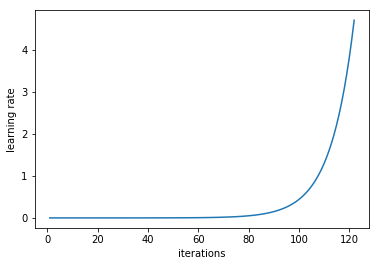

In [27]:
learn.sched.plot_lr()

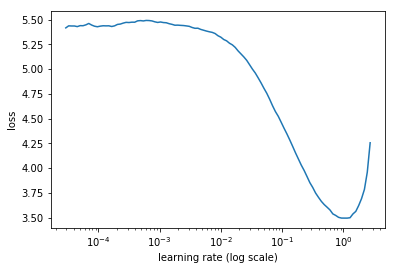

In [28]:
learn.sched.plot()

In [25]:
# 1. Enable data augmentation, and precompute=True

from fastai.transforms import *

arch = resnet34

tfms = tfms_from_model(resnet34, SIZE, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_csv(DATA_DIR, 'train', labels_csv, tfms=tfms, suffix='.jpg', val_idxs=val_idxs, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [29]:
# 3. Train last layer from precomputed activations for 1-2 epochs
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.128817   1.067386   0.768262  
    1      1.084541   0.706755   0.81224                    



[0.70675504, 0.812239583581686]

 95%|█████████▍| 121/128 [00:30<00:01,  3.99it/s, loss=14.7]

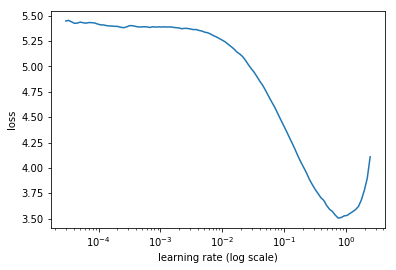

In [30]:
# 4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
#learn.precompute=False
learn = ConvLearner.pretrained(arch, data, precompute=False)
lrf=learn.lr_find()
learn.sched.plot()

In [31]:
learn.fit(1e-2, 4, cycle_len=1)

  4%|▍         | 5/128 [00:01<00:48,  2.52it/s, loss=5.38]

Exception in thread Thread-30:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      2.874989   2.016619   0.648893  
    1      1.660685   1.068301   0.778483                   
    2      1.195219   0.796086   0.81709                    
    3      1.00302    0.677918   0.829395                    



[0.6779182, 0.8293945305049419]

learn.fit(1e-1, 4, cycle_len=1)
epoch      trn_loss   val_loss   accuracy                   
    0      1.195959   0.620292   0.811784  
    1      0.834289   0.57173    0.825977                    
    2      0.689564   0.552942   0.826921                    
    3      0.62258    0.543698   0.822005                    

learn.fit(1e-2, 4, cycle_len=1)
    0      0.450563   0.519204   0.829818  
    1      0.477786   0.509327   0.832259                    
    2      0.436209   0.506666   0.83571                     
    3      0.426876   0.502074   0.832292 

e-1
epoch      trn_loss   val_loss   accuracy                    
    0      0.959256   0.591655   0.81071   
    1      0.830982   0.581532   0.818099                    
    2      0.710563   0.559657   0.816699    

e-2
epoch      trn_loss   val_loss   accuracy                    
    0      0.639296   0.531597   0.835677  
    1      0.597687   0.512893   0.839616                    
    2      0.564076   0.504271   0.842057

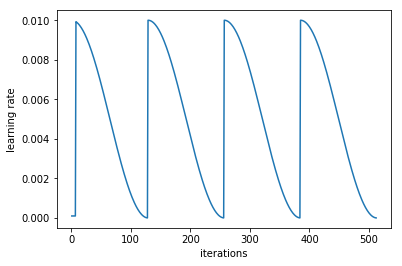

In [32]:
learn.sched.plot_lr()

In [33]:
# 5. Unfreeze all layers
learn.unfreeze()

In [34]:
# 6. Set earlier layers to 3x-10x lower learning rate than next higher layer
# 8. Train full network with cycle_mult=2 until over-fitting

import numpy as np
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.964438   0.643471   0.822559  
    1      0.835123   0.572166   0.827865                    
    2      0.6488     0.559649   0.822526                    
    3      0.654171   0.551126   0.82832                     
    4      0.534113   0.52508    0.836133                    
    5      0.458565   0.516927   0.840592                    
    6      0.434947   0.511891   0.840104                    



[0.5118911, 0.840104166418314]

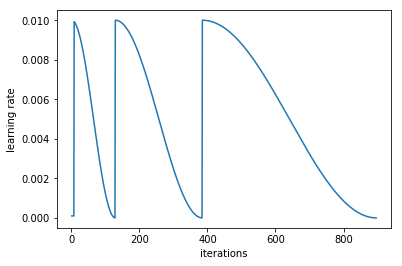

In [21]:
learn.sched.plot_lr()

In [23]:
# 7. Use lr_find() again
lrf=learn.lr_find()

 91%|█████████▏| 117/128 [00:26<00:02,  4.49it/s, loss=2.27] 

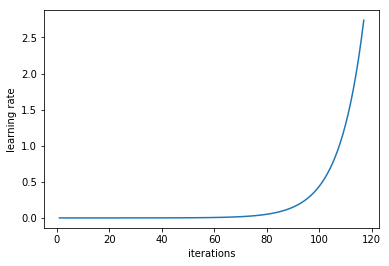

In [24]:
learn.sched.plot_lr()

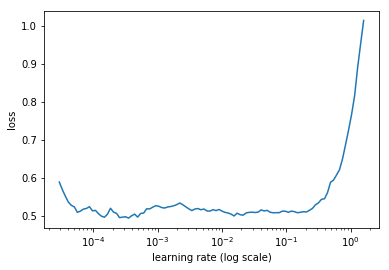

In [25]:
learn.sched.plot()

In [8]:
# 8. Train full network with cycle_mult=2 until over-fitting
# 2nd cycle
arch = resnet34

tfms = tfms_from_model(resnet34, SIZE, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(DATA_DIR, 'train', labels_csv, tfms=tfms, suffix='.jpg', val_idxs=val_idxs, test_name='test', )
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [9]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.890853   1.949764   0.625391  
    1      1.535689   0.83383    0.799544                   
    2      1.07276    0.736813   0.82002                    
    3      0.917282   0.624627   0.819076                    
    4      0.723015   0.564336   0.833757                    
    5      0.610775   0.53961    0.837695                    
    6      0.558727   0.535383   0.836654                    



[0.5353826, 0.836653646081686]

Pessoal

Quem quiser usar TTA, trocar a célula de predição para:

log_preds = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds[0]), axis=0)
No TTA o log_preds vem em uma tupla, onde a primeira entrada dessa tupla é o array com log_preds. E depois como são várias predições para a mesma imagem, precisa dar um np.mean.

## Submissão dos resultados

Carregarmos o aruqivo de exemplo de submissão para e mostramos abaixo.

In [47]:
import pandas as pd
d=pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
d.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


Na função `learn.predict()` a seguir, utilizamos o parâmetro `is_test=True` para gerar as predições dos dados de teste ao invés das prediçõe dos dados de validação, o que é o padrão.

In [83]:
log_preds = learn.predict(is_test=True)
probs = np.exp(log_preds)

Utilizando o Pandas, criamos um data frame com a mesma estrutura do arquivo de submissão de exemplo, utilizando as probabilidades inferidas pelo mdelo nos dados de teste como dados.

In [ ]:
# Cria data frame para submissão, com as probabilidades calculadas pelo modelo --CORRIGIDO

df=pd.DataFrame(
    data=probs,
    columns=d.columns[1:], # Excluir primeira coluna, que é o ID
    index=[f[5:-4] for f in data.test_dl.dataset.fnames] 
)
df.index.name = 'id'

In [78]:
# Cria data frame para submissão, com as probabilidades calculadas pelo modelo
df=pd.DataFrame(
    data=probs,
    columns=d.columns[1::], # Excluir primeira coluna, que é o ID
    index=d.id
)
df.index.name = 'id'

# Salva dataframe em arquivo CSV para envio para o Kaggle
arquivo_submissao = os.path.join(DATA_DIR,'fastai_submission.csv')
df.to_csv(arquivo_submissao)

Formata comando para submissão através da ferramenta oficial do Kaggle

In [87]:
arquivo_submissao = '/home/paperspace/.kaggle/competitions/dog-breed-identification/fastai_submission.csv'
comando = f'kaggle competitions submit -c dog-breed-identification -f {arquivo_submissao} -m "Submissão de teste"'
print(comando)

kaggle competitions submit -c dog-breed-identification -f /home/paperspace/.kaggle/competitions/dog-breed-identification/fastai_submission.csv -m "Submissão de teste"
